In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
import torch.nn as nn
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import bernoulli, binom
from sklearn import linear_model


np.random.seed(42)

# Size

n = 500
d = 100
# K = 100
p = 0.5

In [15]:
#Genarating Genotypes

# toy_genotypes = np.random.binomial(2, p, (n * 3, d))
# np.random.shuffle(toy_genotypes)


toy_genotypes = binom.rvs(2, p, size=(n * 3, d))
np.random.shuffle(toy_genotypes)

print(toy_genotypes.shape)

print(np.mean(toy_genotypes))
print(np.var(toy_genotypes))

(1500, 100)
1.0000866666666666
0.5005933258222222


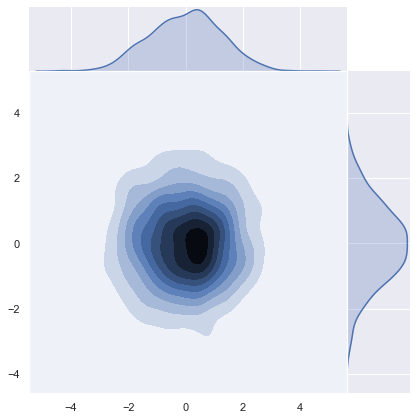

In [16]:
pca = decomposition.PCA(n_components=2)
x_std = StandardScaler().fit_transform(toy_genotypes)
component = pca.fit_transform(x_std)
component.shape

sns.jointplot(x=component[:, 0], y=component[:, 1], kind="kde", space=0)
print()

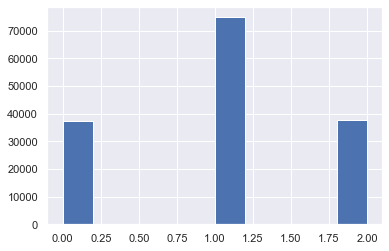

In [17]:
plt.hist(toy_genotypes.flatten())
print()

In [18]:
def simulate_phenotypes(given_genotypes, pis=(0.9, 0.1), gammas=np.array((0., 1.))):
    
    
    n, p = given_genotypes.shape
    print(p)
    
    mixture_assignment = np.random.multinomial(1, pis, size=p)
    
    std_beta = 1
    
    betas = np.random.normal(loc=0.0,
                             scale=gammas[np.where(mixture_assignment)[1]]*std_beta,
                             size=p)
    print(betas.shape)
    
    mult = np.dot(given_genotypes, betas)
    g_var = np.var(mult, ddof=1)
    
    e = np.random.normal(0, np.sqrt(g_var), n)
    
    y = mult + e

    y -= np.mean(y)
    y /= np.var(y)
    
    return y, betas


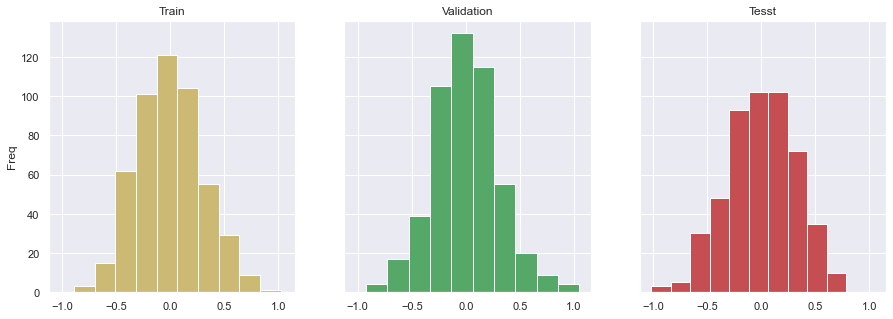

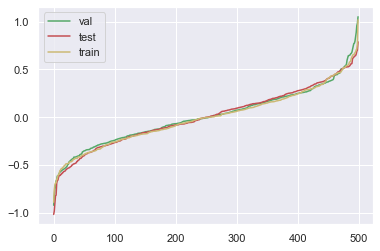

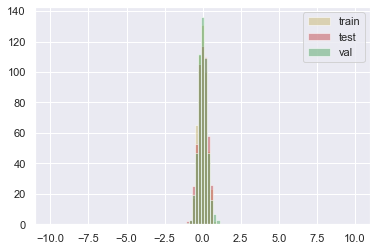

0.05510094673506072 validation
0.033787403450359424 train
0.06051494351690378 test



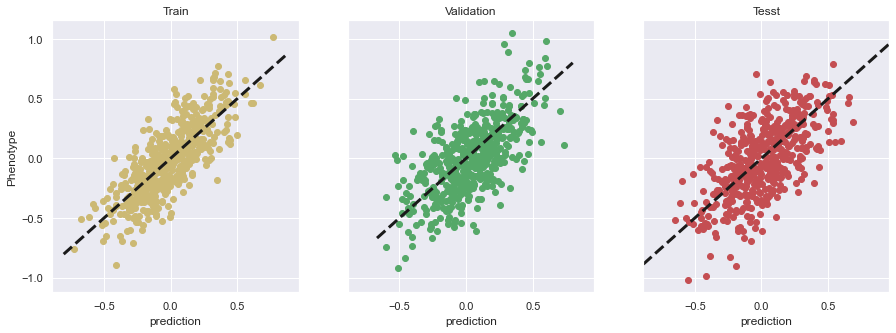

In [19]:
def simulate_phenotypes(given_genotypes, pis=(0.9, 0.1), gammas=np.array((0., 1.))):
    
    
    n, p = given_genotypes.shape
    
    mixture_assignment = np.random.multinomial(1, pis, size=p)
    
    std_beta = 1
    
    betas = np.random.normal(loc=0.0,
                             scale=gammas[np.where(mixture_assignment)[1]]*std_beta,
                             size=p)
    
    mult = np.dot(given_genotypes, betas)
    g_var = np.var(mult, ddof=1)
    
    e = np.random.normal(0, np.sqrt(g_var), n)
    
    y = mult + e

    y -= np.mean(y)
    y /= np.var(y)
    
    return y, betas

toy_phenotypes, betas = simulate_phenotypes(toy_genotypes)


test_genotypes = toy_genotypes[0:n,:]
# test_phenotypes, betas_test = simulate_phenotypes(test_genotypes)
test_phenotypes = toy_phenotypes[0:n,]


val_genotypes = toy_genotypes[n:2*n,:]
# val_phenotypes, betas_val = simulate_phenotypes(val_genotypes)
val_phenotypes = toy_phenotypes[n:2*n,]

train_genotypes = toy_genotypes[2 * n:,:]
# train_phenotypes, betas_train = simulate_phenotypes(train_genotypes)
train_phenotypes = toy_phenotypes[2 * n:,]


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

axis[0].hist(train_phenotypes, color='y')
axis[0].set_title("Train")

axis[1].hist(val_phenotypes, color='g')
axis[1].set_title("Validation")

axis[2].hist(test_phenotypes, color='r')
axis[2].set_title("Tesst")

for ax in axis.flat:
    ax.set(ylabel='Freq')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('phenotypes_dist.pdf')



# plt.scatter(np.arange(val_phenotypes.shape[0]), np.sort(val_phenotypes), color='r')
# plt.scatter(np.arange(test_phenotypes.shape[0]), np.sort(test_phenotypes), color='g')
# plt.scatter(np.arange(train_phenotypes.shape[0]), np.sort(train_phenotypes), color='y')
plt.plot(np.sort(val_phenotypes), color='g', label='val')
plt.plot(np.sort(test_phenotypes), color='r', label='test')
plt.plot(np.sort(train_phenotypes), color='y', label='train')
plt.legend(loc='upper left')
print("")
plt.savefig('phenotypes_dist_cont.pdf')
plt.show()

bins = np.linspace(-10, 10, 100)

plt.hist(train_phenotypes, bins, alpha=0.5, color='y', label='train')
plt.hist(test_phenotypes, bins, alpha=0.5, color='r', label='test')
plt.hist(val_phenotypes, bins, alpha=0.5, color='g', label='val')

plt.legend(loc='upper right')
plt.savefig('phenotypes_dist_together.pdf')
print("")
plt.show()



from sklearn import svm

reg = linear_model.Ridge(alpha=.5)
reg.fit(train_genotypes, train_phenotypes)

# per = reg.predict(test_genotypes)
# plt.scatter(per, test_phenotypes)

# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
# plt.show()

# print(np.mean((test_phenotypes - per) ** 2))


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

# del per
per = reg.predict(val_genotypes)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

print(np.mean((val_phenotypes - per) ** 2), 'validation')

del per

per = reg.predict(train_genotypes)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

print(np.mean((train_phenotypes - per) ** 2), 'train')

del per

per = reg.predict(test_genotypes)


axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
print(np.mean((test_phenotypes - per) ** 2), 'test')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('linear_model_res.pdf')





(1500,)
(1500,) SHAPE
(1500,)
9.473903143468002e-18
0.01205635666806736
----
(1500, 1500)
(1500,)


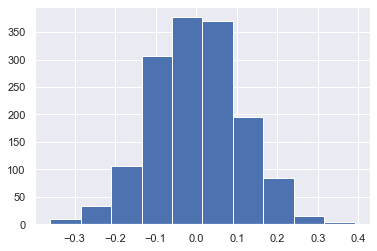

1.0012506666666667
0.500099769166222
0.00035236789887460905
0.013135945464315459
---
0.9988666666666667
0.49907604888888885
-0.010811562241443777
0.010634095981652653
---
0.999264
0.49961812497066665
0.010459194342569198
0.012172619770701566
---
(500,) (500, 1500)
(500,) (500, 1500)
(500,) (500, 1500)


In [25]:
# simu = GWASSimulator(toy_genotypes)
# simu.simulate_mixture_assignment()
# betas = simu.simulate_betas()[1]
# toy_phenotypes = simu.simulate_phenotypes()

# print(simu.mixture_assignment[1])

toy_phenotypes, betas = simulate_phenotypes(toy_genotypes)

print(betas.shape, "SHAPE")
print(toy_phenotypes.shape)

print(np.mean(toy_phenotypes))
print(np.var(toy_phenotypes))
print("----")

# # del y, e, mult
print(toy_genotypes.shape)
print(toy_phenotypes.shape)
plt.hist(toy_phenotypes.flatten())
plt.show()

test_genotypes = toy_genotypes[0:n,:]
print(np.mean(test_genotypes))
print(np.var(test_genotypes))
test_phenotypes = toy_phenotypes[0:n,]
print(np.mean(test_phenotypes))
print(np.var(test_phenotypes))
print("---")

val_genotypes = toy_genotypes[n:2*n,:]
print(np.mean(val_genotypes))
print(np.var(val_genotypes))
val_phenotypes = toy_phenotypes[n:2*n,]
print(np.mean(val_phenotypes))
print(np.var(val_phenotypes))
print("---")

train_genotypes = toy_genotypes[2 * n:,:]
print(np.mean(train_genotypes))
print(np.var(train_genotypes))
train_phenotypes = toy_phenotypes[2 * n:,]
print(np.mean(train_phenotypes))
print(np.var(train_phenotypes))
print("---")


print(train_phenotypes.shape, train_genotypes.shape)
print(test_phenotypes.shape, test_genotypes.shape)
print(val_phenotypes.shape, val_genotypes.shape)



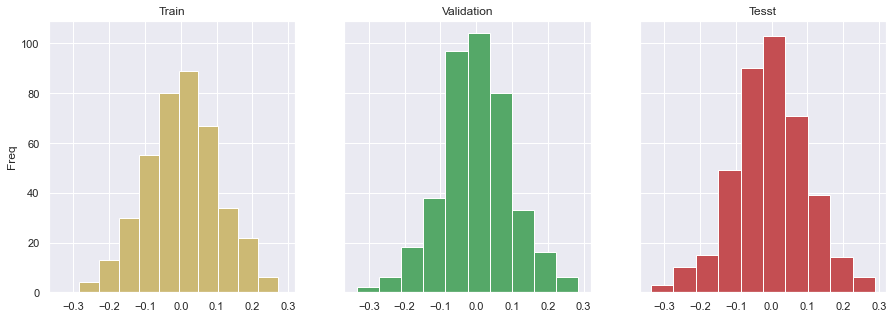

In [8]:
figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

axis[0].hist(train_phenotypes, color='y')
axis[0].set_title("Train")

axis[1].hist(val_phenotypes, color='g')
axis[1].set_title("Validation")

axis[2].hist(test_phenotypes, color='r')
axis[2].set_title("Tesst")

for ax in axis.flat:
    ax.set(ylabel='Freq')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

plt.show()
figure.savefig('Plots/phenotypes_dist.pdf')



In [7]:
prob = binom.cdf(train_genotypes, 2, p)
print(np.allclose(train_genotypes, binom.ppf(prob, 2, p)))

prob = binom.cdf(val_genotypes, 2, p)
print(np.allclose(val_genotypes, binom.ppf(prob, 2, p)))

prob = binom.cdf(test_genotypes, 2, p)
print(np.allclose(test_genotypes, binom.ppf(prob, 2, p)))

True
True
True


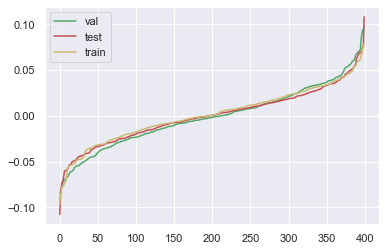

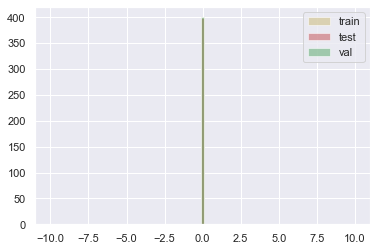

In [8]:

# plt.scatter(np.arange(val_phenotypes.shape[0]), np.sort(val_phenotypes), color='r')
# plt.scatter(np.arange(test_phenotypes.shape[0]), np.sort(test_phenotypes), color='g')
# plt.scatter(np.arange(train_phenotypes.shape[0]), np.sort(train_phenotypes), color='y')
plt.plot(np.sort(val_phenotypes), color='g', label='val')
plt.plot(np.sort(test_phenotypes), color='r', label='test')
plt.plot(np.sort(train_phenotypes), color='y', label='train')
plt.legend(loc='upper left')
plt.savefig('Plots/phenotypes_dist_cont.pdf')
plt.show()

bins = np.linspace(-10, 10, 100)

plt.hist(train_phenotypes, bins, alpha=0.5, color='y', label='train')
plt.hist(test_phenotypes, bins, alpha=0.5, color='r', label='test')
plt.hist(val_phenotypes, bins, alpha=0.5, color='g', label='val')

plt.legend(loc='upper right')
plt.savefig('Plots/phenotypes_dist_together.pdf')
plt.show()


0.01651894302405447 validation
1.0953442179490096e-08 train
0.01642093700304544 test


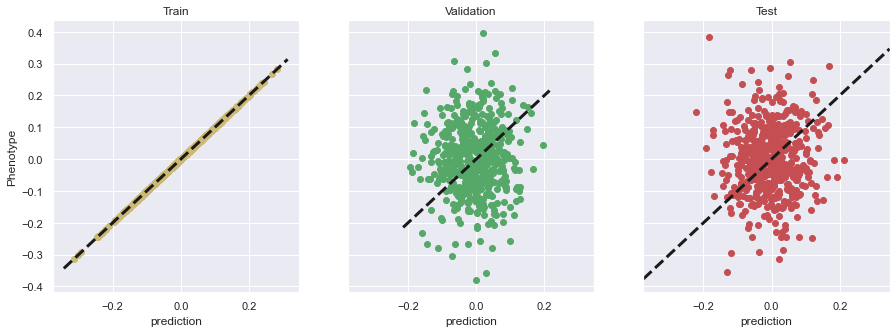

In [28]:
from sklearn import svm

reg = linear_model.Ridge(alpha=.5)
reg.fit(train_genotypes, train_phenotypes)

# per = reg.predict(test_genotypes)
# plt.scatter(per, test_phenotypes)

# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
# plt.show()

# print(np.mean((test_phenotypes - per) ** 2))


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

# del per
per = reg.predict(val_genotypes)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

print(np.mean((val_phenotypes - per) ** 2), 'validation')

del per

per = reg.predict(train_genotypes)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

print(np.mean((train_phenotypes - per) ** 2), 'train')

del per

per = reg.predict(test_genotypes)


axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Test")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
print(np.mean((test_phenotypes - per) ** 2), 'test')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

plt.show()
figure.savefig('Plots/linear_model_res.pdf')




In [7]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, phenotypes, batch_size=1):

        self.phenotypes = phenotypes
        self.genotype_matrix = genotype_matrix

        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]        
        samples = real_samples
        labels = self.phenotypes[idx, ]
        batch = {'x': samples, 'y': labels}

        return batch

    
    
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data    

# dataset = Loader(toy_genotypes, toy_phenotypes, toy_matrix, toy_phenotypes)
dataset = Loader(train_genotypes, train_phenotypes)

# for batch_ndx, sample in enumerate(loader):
# #     print(sample['samples'][0][1])
# #     print(sample['identity'][0][1])
#     print(sample)

#     break

In [8]:
from scipy.stats import gamma
alpha_gam = 2
beta_gam = 1

from scipy.stats import norm


def prior_sample(size=1):
    sigma = gamma.rvs(alpha_gam, scale=1/beta_gam, size=size)
    beta = norm.rvs(loc=0, scale=sigma, size=size)
    return beta, sigma

def prior_prob(beta, sigma):
    p_sig = gamma.pdf(sigma, alpha_gam, scale=1/beta_gam)
    p_beta = norm.pdf(beta, loc=0, scale=sigma)

    p_beta[np.where(np.isnan(p_beta))] = 1e-5
    
    return p_beta, p_sig

# b, s = prior_sample((10, 5))
# p_b, p_s = prior_prob(b, s)
# print(p_b)

In [13]:
from scipy.stats import multivariate_normal

def metropolis_heisting(cur_beta, cur_sigma, cur_prob_theta, geno_mat, h_classifier):
    
#     changed_value = np.full(cur_theta_prob.shape, 1)
    counter = 0

    while(True):
        new_sigma = multivariate_normal(cur_sigma, var).rvs(size=1)
        new_beta = multivariate_normal(cur_beta, var).rvs(size=1)

        new_prior, _ = prior_prob(new_beta, new_sigma)
        new_ys = np.dot(geno_mat, new_beta)
        with torch.no_grad():
            r_value = h_classifier(new_ys, new_prior).cpu().detach().numpy()
            r_value = np.mean(r_value, axis=0)
            r_value = r_value / (1 - r_value)
            new_theta_prob = r_value * new_prior


            rho = (new_theta_prob) / (cur_prob_theta + 1e-7)
            rho[rho > 1] = 1
    #         rho = rho * changed_value
    #        rho = min(1, (new_theta_prob)/(cur_theta_prob))
            random_num = np.random.rand()
        
            if np.isnan(np.sum(rho)):
                print(np.isnan(np.sum(cur_prob_theta)))
                print(np.isnan(np.sum(new_prob_theta)))

            if random_num < np.mean(rho):
                cur_beta = new_beta
                cur_sigma = new_sigma
                cur_theta_prob = new_theta_prob
                return cur_sigma, cur_beta, cur_theta_prob, new_ys

        counter += 1
        
        if counter > 10:
#             print("It Takes quite time :(")
            cur_beta = (new_beta + cur_beta) / 2
            cur_sigma = (new_sigma + cur_sigma) / 2
            cur_theta_prob = (new_theta_prob + cur_prob_theta) / 2
            return cur_sigma, cur_beta, cur_theta_prob, new_ys
            
#         cur_beta[rho > random_num] = new_beta[rho > random_num]
#         cur_sigma[rho > random_num] = new_sigma[rho > random_num]
#         cur_theta_prob[rho > random_num] = new_theta_prob[rho > random_num]
#         changed_value[rho > random_num] = 0


#         if np.sum(changed_value) == 0:
#             return cur_sigma, cur_beta, cur_theta_prob, new_ys
    
# _,a, _, _ = metropolis_heisting(toy_genotypes, lambda x: 0.5)
# print(a.shape)

In [14]:
class Classifier(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(Classifier, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        self.layer_1 = nn.Linear(input_dim, 1)
        self.layer_out = nn.Linear(2, 1)
        

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, beta, label=None):

        y = torch.Tensor(y).to(device)
        beta = torch.Tensor(beta).to(device)
        
        beta_summaries = self.layer_1(beta)
        x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries[None, :], y.shape[0], dim=0)], dim=1)
        x = self.layer_out(x)
        

        if label is not None:

            loss = self.criterion(x, label[:, None])
            return x, loss
        
        return x
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

In [15]:
class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        self.layer_1 = nn.Linear(input_dim, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, beta, label=None):
        y = torch.Tensor(y).to(device)
        beta = torch.Tensor(beta).to(device)
        
        y = torch.repeat_interleave(y[:, None], d, dim=-1)
        beta = torch.repeat_interleave(beta[None, :], y.shape[0], dim=0)
        x = torch.cat([beta, y], dim=-1)
        
#         out = self.linear(x)
#         out = self.activation(out)
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        if label is not None:

            loss = self.criterion(x, label[:, None])
            return x, loss
        
        return x
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp







# class LogisticRegression(nn.Module):
    
#     def __init__(self, input_dim, num_classes=1):
#         super(LogisticRegression, self).__init__()
# #         self.linear = nn.Linear(input_dim, 1)
# #         self.activation = nn.Sigmoid()

#         # Number of input features is 12.
#         self.summary_layer = nn.Sequential(nn.Linear(input_dim, 32),
# #                                           nn.BatchNorm1d(32),
#                                           nn.ReLU(),
#                                           nn.Linear(32, 1))

        
#         self.layer_out = nn.Sequential(nn.Linear(2, 8),
#                                        nn.ReLU(),
#                                        nn.BatchNorm1d(8),
#                                        nn.Linear(8, 2),
#                                        nn.ReLU(),
#                                        nn.BatchNorm1d(2),
#                                        nn.Linear(2, 1),
#                                        nn.ReLU())
        

#         self.criterion = nn.BCEWithLogitsLoss()
        
#     def cross_entropy(self, x, y):
#         n_d, h_d = x.shape
        
#         n_theta = x[0: int(n_d / 2),:]
#         n_x = x[int(n_d / 2):,:]
        
#         return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
#     def forward(self, y, beta, label=None):
#         y = torch.Tensor(y).to(device)
#         beta = torch.Tensor(beta).to(device)[None, :]
        
#         beta_summaries = self.summary_layer(beta)
#         x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries, y.shape[0], dim=0)], dim=1)
#         x = self.layer_out(x)
        
#         if label is not None:

#             loss = self.criterion(x, label[:, None])
#             return x, loss
        
#         return x
    
#     def get_n_params(model):
#         pp=0
#         for p in list(model.parameters()):
#             nn=1
#             for s in list(p.size()):
#                 nn = nn*s
#             pp += nn
#         return pp

  0%|          | 0/500 [00:00<?, ?it/s]

Running on the CPU
0.9
804


  4%|▍         | 20/500 [03:54<1:30:12, 11.28s/it]

1.0843733281012704
EPOCH 20
Total Error tensor(3.2156, grad_fn=<AddBackward0>)
Using proper sets


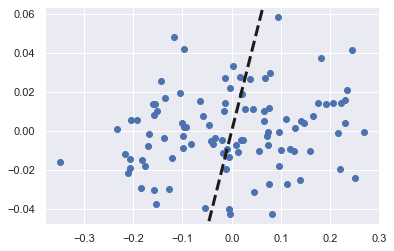

  8%|▊         | 40/500 [10:07<2:41:07, 21.02s/it]

1.031749392182391
EPOCH 40
Total Error tensor(2.9650, grad_fn=<AddBackward0>)
Using proper sets


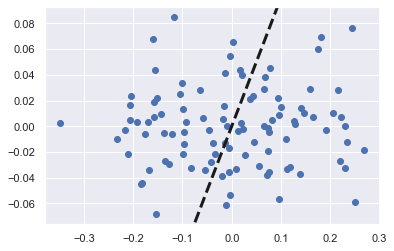

  9%|▉         | 46/500 [11:44<1:55:50, 15.31s/it]


KeyboardInterrupt: 

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

num_epochs = 500
EPSILON = (2 * EPSILON_PREV) / 3
EPSILON = 0.9
print(EPSILON)

lambda_val = 0.1

BATCH_SIZE = 64
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

classifier = Classifier(d).to(device)
print(classifier.get_n_params())

optimizer = optim.Adam(classifier
                         .parameters(), lr=0.0002)

losses = []
distances = []


denum = train_genotypes.shape[0] / BATCH_SIZE

losses = []

proper_beta_samples = []

import time

for epoch in tqdm(range(num_epochs)):
    
    error_sum = 0
    distance_sum = 0
    
#     var = np.eye(d) * (0.75 / (epoch + 1))
    var = np.eye(d) * 0.1

    cur_beta, cur_sigma = prior_sample(d)

    cur_ys = np.dot(train_genotypes, cur_beta)
    cur_ys -= np.mean(cur_ys)
    cur_ys /= np.var(cur_ys)
    cur_prior, _ = prior_prob(cur_beta, cur_sigma)
    cur_r_value = classifier(cur_ys, cur_beta).cpu().detach().numpy()
    cur_r_value = np.mean(cur_r_value, axis=0)
    cur_r_value = cur_r_value / (1 - cur_r_value)

    cur_theta_prob = cur_r_value * cur_prior

    for n_batch, batch in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        N = batch['x'].size(0)
        
        geno_batch = batch['x'].cpu().detach().numpy()
        pheno_batch = batch['y'].cpu().detach().numpy()
        
        sampled_sigma, sampled_beta, prob_theta, sampled_y = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
#         sampled_y = torch.sigmoid(torch.tensor(sampled_y)).numpy()
        
#         sampled_y = sampled_y
        sampled_y -= sampled_y.mean()
        sampled_y /= sampled_y.std()
#         sampled_y[sampled_y > 0] = 1.
#         sampled_y[sampled_y <= 0] = 0.
        
        distance = np.mean((sampled_y - pheno_batch) ** 2)
        
#         print(distance)
        distance_sum += distance
        
        _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
        _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
        
#         _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
#         loss_f *= ((distance ** 2))
                             
#         _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
#         loss_r *= ((distance ** 2))
        
        loss = loss_f + loss_r
        loss *= (distance ** 2)
#         loss += lambda_val * torch.abs(torch.norm(torch.tensor(sampled_beta), float('inf')))
        loss.backward()

        
        optimizer.step()
        error_sum += loss
        
        if distance <= EPSILON:
            proper_beta_samples.append(sampled_beta)
#             print("ADDED")
            
        cur_beta = sampled_beta.copy()
        cur_sigma = sampled_sigma.copy()
        cur_theta_prob = prob_theta
        
    if epoch % 20 == 0 and epoch >= 20:
        print(distance)
        print("EPOCH", epoch)
        print("Total Error", error_sum)

        if len(proper_beta_samples) > 0:
                print("Using proper sets")
                proper_beta_samples_val = np.array(proper_beta_samples)
                proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)
                proper_beta_samples_val.shape

                val_y = np.dot(val_genotypes, proper_beta_samples_val)

        else:   
                val_y = np.dot(val_genotypes, sampled_beta)
                
        val_y -= np.mean(val_y)
        val_y /= np.var(val_y)

        wrong_preds = np.sum(np.abs(val_y - val_phenotypes))

        plt.scatter(val_phenotypes, val_y)
        xpoints = ypoints = plt.xlim()
        plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
        plt.show()
#     print(distance_sum / denum)
        
    losses.append([error_sum / denum])
    distances.append([distance_sum / denum])
        

In [ ]:
plt.plot(np.arange(epoch + 1), losses)
plt.show()
plt.plot(np.arange(epoch + 1), distances)
plt.show()
distances = np.array(distances)
plt.plot(np.arange(len(distances[distances < EPSILON])), distances[distances < EPSILON])
print(np.mean(distances))
plt.show()

(19, 180)
(180,)
0.022835138298035396
-1.4895374637663332
1.605664404341722


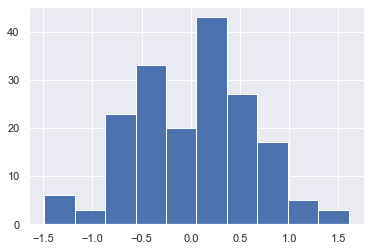

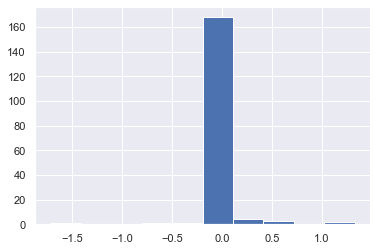

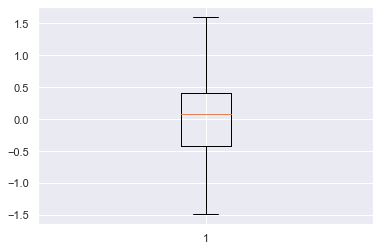

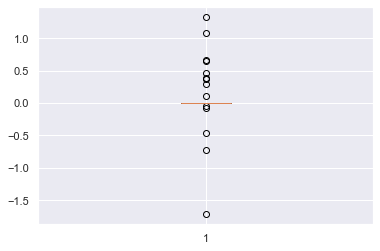

In [19]:
proper_beta_samples_np = np.array(proper_beta_samples).T
print(proper_beta_samples_np.T.shape)
proper_beta_samples_mean = np.mean(proper_beta_samples_np.T, axis=0)
print(proper_beta_samples_mean.shape)


print(np.mean(proper_beta_samples_mean))
print(np.min(proper_beta_samples_mean))
print(np.max(proper_beta_samples_mean))

plt.hist(proper_beta_samples_mean)
plt.show()
plt.hist(betas)
plt.show()

plt.boxplot(proper_beta_samples_mean)
plt.show()

plt.boxplot(betas)
plt.show()

14
(19,)


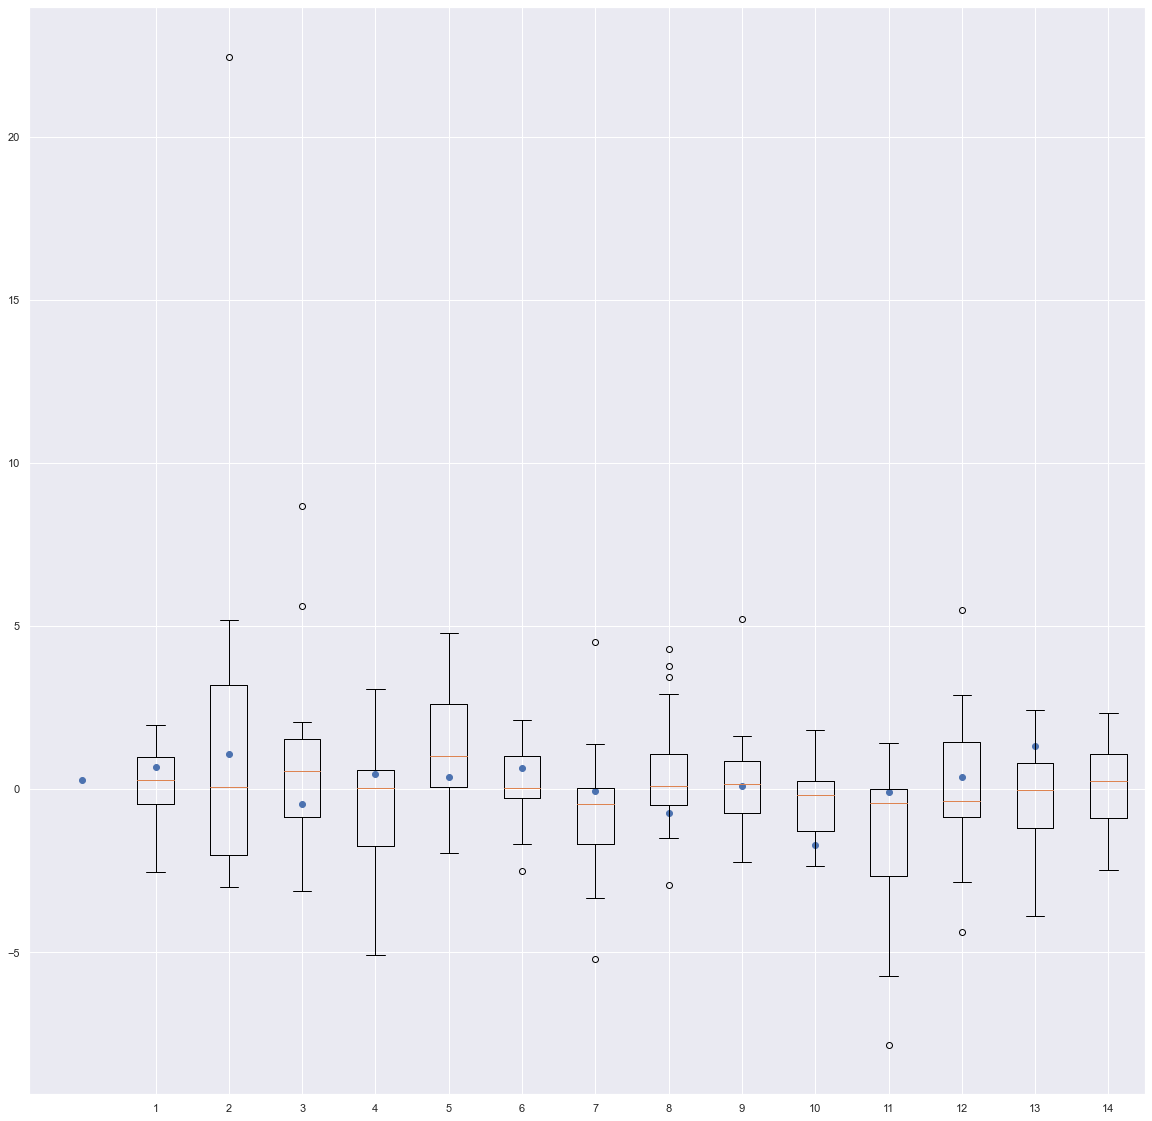

In [20]:
to_plot = []
for i in range(proper_beta_samples_np[betas != 0].shape[0]):
    to_plot += [proper_beta_samples_np[betas != 0][i, :]]

print(len(to_plot))
print(to_plot[0].shape)
fig=plt.figure(1,figsize=(20,20))
ax=fig.add_subplot(111)
bp=ax.boxplot(to_plot)
fig.savefig('boxplot2_new.png',bbox_inches='tight')


plt.scatter(np.arange(len(to_plot)), betas[betas!=0])
plt.show()

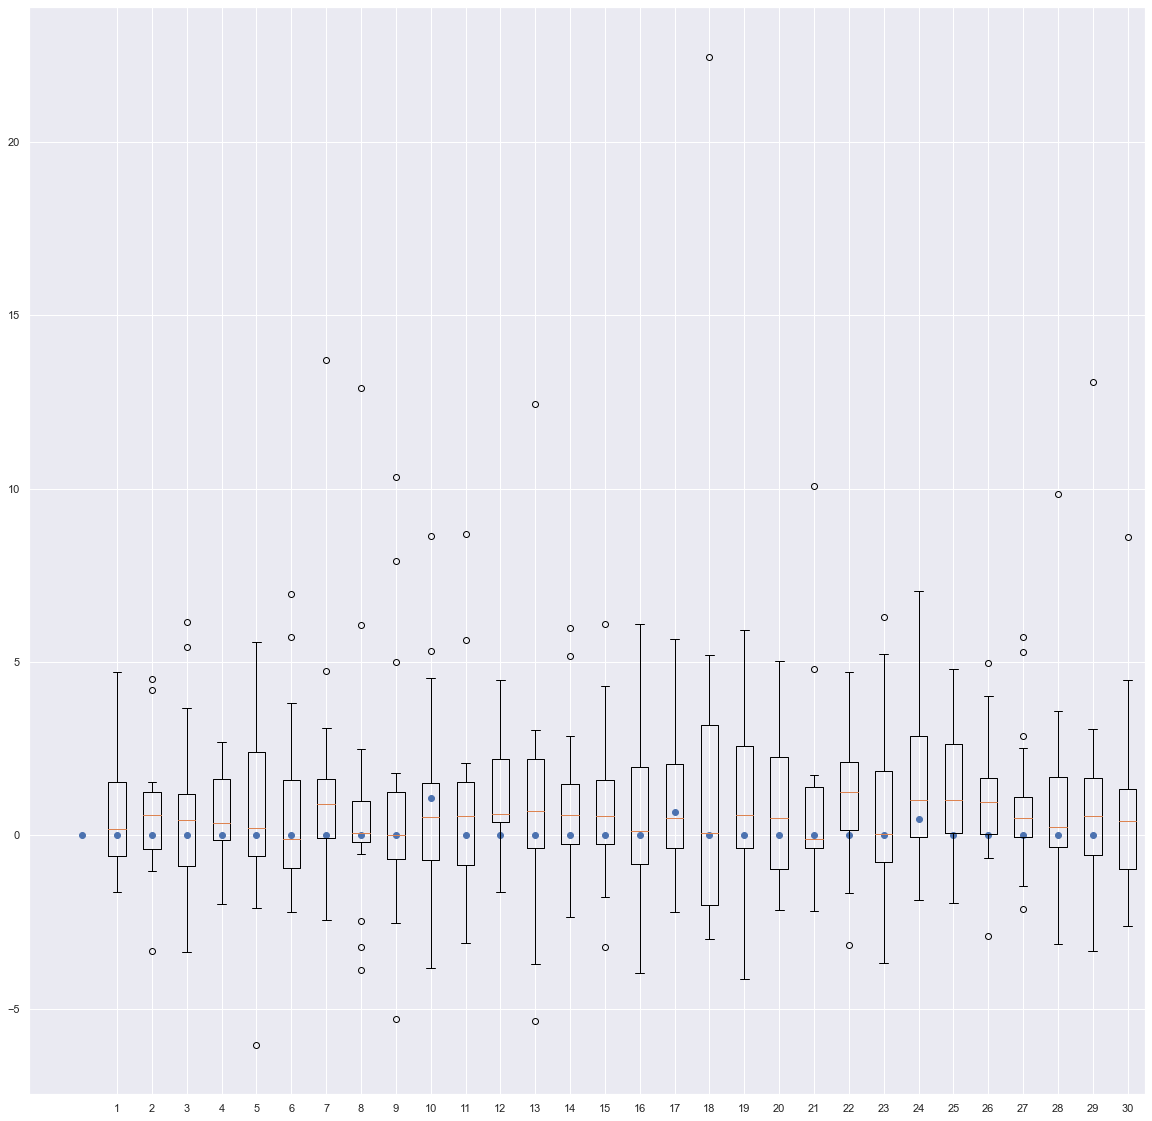

In [21]:
ind = np.argpartition(proper_beta_samples_mean, -30)[-30:]

to_plot = []
for i in ind:
    to_plot += [proper_beta_samples_np[i, :]]
# print(len(to_plot))


fig=plt.figure(1,figsize=(20,20))
ax=fig.add_subplot(111)
bp=ax.boxplot(to_plot)
fig.savefig('boxplot_oth_new.png',bbox_inches='tight')

plt.scatter(np.arange(len(ind)), betas[ind])
plt.show()

0.15490972420367624


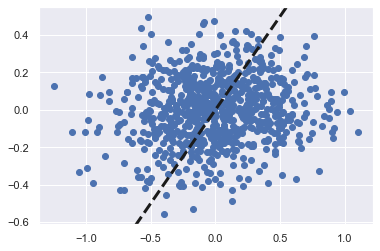

In [22]:
test_y = np.dot(test_genotypes, proper_beta_samples_mean)
test_y -= np.mean(test_y)
test_y /= np.var(test_y)

wrong_preds = np.sum(np.abs(test_y - test_phenotypes))
print(np.mean((test_y - test_phenotypes) ** 2))
plt.scatter(test_phenotypes, test_y)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

0.12845922892276454


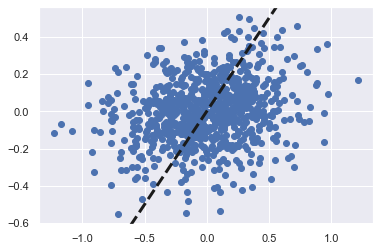

In [23]:
test_y = np.dot(train_genotypes, proper_beta_samples_mean)
test_y -= np.mean(test_y)
test_y /= np.var(test_y)

wrong_preds = np.sum(np.abs(test_y - train_phenotypes))
print(np.mean((test_y - train_phenotypes) ** 2))
plt.scatter(train_phenotypes, test_y)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

In [24]:
print(betas.shape)
print(proper_beta_samples_mean)
print(proper_beta_samples_mean)
print(proper_beta_samples_mean[betas != 0])

print(np.mean(np.abs(proper_beta_samples_mean - betas)))

(180,)
[-0.37460202  0.79278808  0.70325213  0.56366938 -0.1097218   0.17381881
 -1.2816747   0.15745143  0.88575312  0.38657865 -0.46909183 -0.00540172
 -0.50764664 -0.70799046  0.74294747 -0.07845097  0.2975932   0.23392377
 -0.04438218  0.3820765   0.46776623  0.76256336 -1.29884035  0.58383431
  0.70904183 -0.56333527  1.04135535  0.15056342  1.6056644   0.09772646
  0.09931736  1.05579308  0.42435217  0.12629792 -0.04775496 -0.1555796
 -0.55549123 -0.42039847 -0.61133883 -0.23040529 -0.69551979 -0.39659159
  0.37545094 -0.38272359  0.55994193 -1.24293148  0.53627515  0.25585307
 -0.61991781  0.44356479  0.27203785  0.35687952  0.3549383   0.23953251
 -0.1010145  -1.26780679  0.59540485  0.08170354  0.06809423 -0.42643959
  0.74929402 -0.29889565 -0.30466699  0.30853366 -0.43704448 -0.65052378
 -0.58684231  0.37597964 -0.59057312 -0.49402219 -0.20463465  0.04074307
  0.0836602  -0.22134693  0.40920681  1.41626095 -0.67666526  0.75150323
  0.91310119  0.24906133 -0.62419901 -0.58802